In [1]:
import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import glob
import datetime

%matplotlib inline

In [2]:
date_start = '2017-01-01'
date_end   = '2017-04-23'

df = {}
df['in'] = pd.read_csv(
    './data/cur.zentrum.nibelungenbruecke.traffic.risc-software.at.csv', 
    parse_dates = [0], 
    index_col = 0
)
df['in' ] = df['in'][date_start:date_end]

df['out'] = pd.read_csv(
    './data/cur.urfahr.nibelungenbruecke.traffic.risc-software.at.csv', 
    parse_dates = [0], 
    index_col = 0
)
df['out'] = df['out'][date_start:date_end]

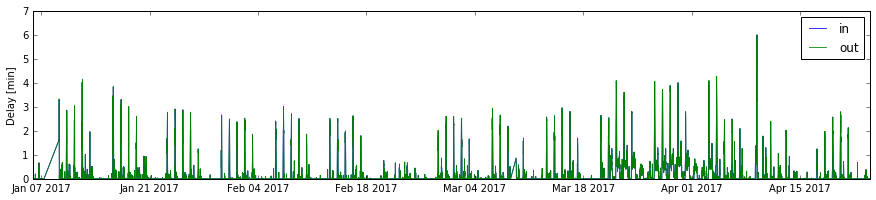

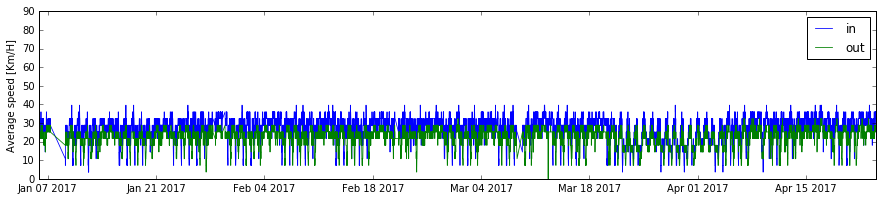

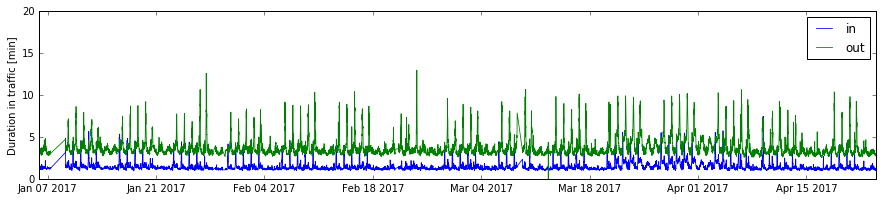

In [3]:
plt.figure(figsize=(15,3))
plt.plot(df['in'].delay/60, lw=0.8, label='in' )
plt.plot(df['in'].delay/60, lw=0.8, label='out')
plt.ylabel('Delay [min]')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(15,3))
plt.plot(df['in'].delayed_average_speed, lw=0.8,label='in' )
plt.plot(df['out'].delayed_average_speed, lw=0.8,label='out' )
plt.ylabel('Average speed [Km/H]')
plt.ylim([0,90])
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(15,3))
plt.plot(df['in'].total_duration_in_traffic/60 , lw=0.8,label='in' )
plt.plot(df['out'].total_duration_in_traffic/60, lw=0.8,label='out' )
plt.ylabel('Duration in traffic [min]')
plt.ylim([0,20])
plt.legend(loc='best')
plt.show()

In [4]:
def create_date_matrix(data): 
    hdata = pd.DataFrame(np.zeros([len(data.resample('d').mean()),24]),index=data.resample('d').mean().index)
    _dd_ = data.resample('60T').mean()
    for i in range(0,len(hdata)):
        if len(hdata.ix[i]) == len(np.array(_dd_[_dd_.index.date == hdata.index[i].date()].values)) :
            hdata.ix[i] = np.array(_dd_[_dd_.index.date == hdata.index[i].date()].values)                  
    hdata = hdata.fillna(0)
    return hdata

import matplotlib.dates as mdates

def plot_date_matrix( matrix_data , feature = 'delay', axe=None):
    sundays = pd.Series(matrix_data[matrix_data.index.dayofweek==0].index)
    fig = None
    if axe == None:
        fig, axe = plt.subplots(figsize=[4,13])
    axe.imshow(matrix_data, interpolation='none', cmap='YlGnBu')
    axe.tick_params(axis="both", which="both", bottom="on", top="on",
                    labelbottom="on", labeltop='on', left="on", right="off", labelleft="on") 
    axe.axvline(x=7   , ls='--', lw=0.8)
    axe.axvline(x=15.5, ls='--', lw=0.8)
    xticks = range(0,24,4)
    yticks = range(0,len(matrix_data),7)
    
    axe.set_xticks(xticks)
    axe.set_xlabel('day hour', fontsize = 14)
    axe.set_yticks(yticks)
    axe.set_yticklabels(sundays.apply(lambda x: x.strftime('%B %d')), fontsize=14)
    axe.yaxis_date()

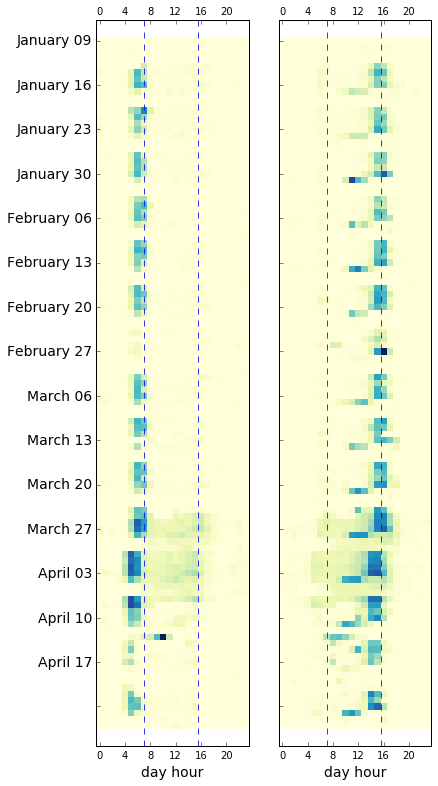

In [5]:
f, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(6,13))
plot_date_matrix(  create_date_matrix( df['in'].delay  ), feature = 'delay [min]', axe=ax1)
plot_date_matrix(  create_date_matrix( df['out'].delay ), feature = 'delay [min]', axe=ax2)

plt.show()

The dashed lines show a typical office time between 7:00 and 15:30 with 30 minutes lunch break that corresponds to 8h work. we can see that the delays fits very well these time, for the weekend, the situation is opposit. Let have a look the average delay in a day.

In [6]:
def plot_delay(data, title = ''):
    data['hod'] = data.index.time
    data['wod'] = (data.index.weekday >= 0) & (data.index.weekday <= 4)
    dd_wod = data[data['wod']==True ].groupby('hod').mean()
    dd_wnd = data[data['wod']==False].groupby('hod').mean()


    plt.figure(figsize=(10,4))
    plt.plot(dd_wod.index,dd_wod.delay/60, c='red' , label='working day')
    plt.plot(dd_wnd.index,dd_wnd.delay/60, c='blue', label='weekend')

    plt.plot(data.hod[data['wod']==True] ,data.delay[data['wod']==True ]/60., alpha=0.1, c='red' , label='')
    plt.plot(data.hod[data['wod']==False],data.delay[data['wod']==False]/60., alpha=0.1, c='blue', label='')
    plt.ylabel('delay [min]')
    plt.title(title)
    plt.legend(loc='best')
    return (dd_wod, dd_wnd)

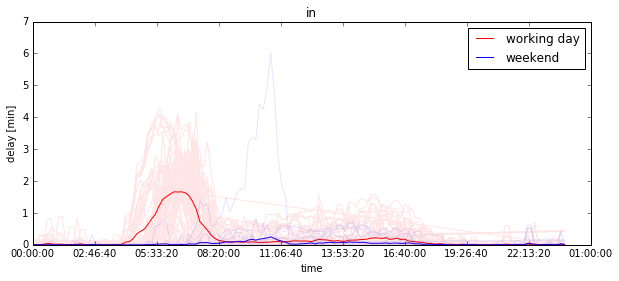

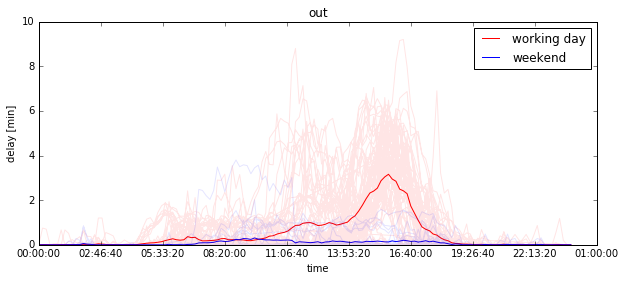

In [7]:
hist_wod,hist_wnd = plot_delay(df['in' ], title='in')
hist_wod,hist_wnd = plot_delay(df['out'], title='out')

This information will be used later to predict for example unexpected events.